# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

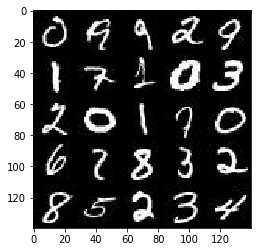

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

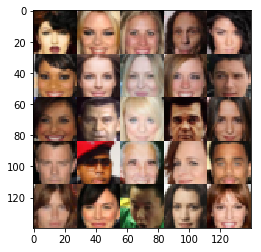

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="Input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="Input_z")
    learning_rate = tf.placeholder(tf.float32)

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop = 0.7
    with tf.variable_scope("discriminator", reuse=reuse):
        #Input to discriminator is 28x28xChannels
        disc = tf.layers.conv2d(images, 64, 5, strides=1, padding='same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        disc = tf.maximum(alpha*disc, disc)
        
        #shape=28x28x64
        disc = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #disc = tf.layers.batch_normalization(disc, training=True)
        disc = tf.maximum(alpha*disc, disc)
        disc = tf.nn.dropout(disc, drop)
        
        #shape=14x14x128
        disc = tf.layers.conv2d(disc, 256, 5, strides=2, padding='same',
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        disc = tf.layers.batch_normalization(disc, training=True)
        disc = tf.maximum(alpha*disc, disc)
        disc = tf.nn.dropout(disc, drop)
        
        #Flattening
        flat = tf.contrib.layers.flatten(disc)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    drop = 0.5
    reuse = True if is_train==False else False
    with tf.variable_scope("generator", reuse=reuse):
        #gen = tf.nn.dropout(tf.layers.dense(z, 7*7*512), drop)
        gen = tf.layers.dense(z, 7*7*256)
        gen = tf.reshape(gen, (-1,7,7,256))
        gen = tf.layers.batch_normalization(gen, training=is_train)
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        #Input is 256
        gen = tf.layers.conv2d_transpose(gen, 128, 5, strides=2, padding='same', 
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #gen = tf.layers.batch_normalization(gen, training=is_train)
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        #Now 14x14x128
        gen = tf.layers.conv2d_transpose(gen, 64, 5, strides=2, padding='same',
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #gen = tf.layers.batch_normalization(gen, training=is_train)
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        #Now 28x28x64      
        gen = tf.layers.conv2d_transpose(gen, 32, 5, strides=1, padding='same',
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #gen = tf.layers.batch_normalization(gen, training=is_train)
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        #Now 28x28x32
        
        logits = tf.layers.conv2d_transpose(gen, out_channel_dim, 5, strides=1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        out = tf.tanh(logits)
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)*0.9))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)))
    
    disc_total_loss = disc_loss_real + disc_loss_fake
    
    return (disc_total_loss, gen_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    return (disc_train_opt, gen_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    channels = 3 if data_image_mode == 'RGB' else 1
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0    
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                #For printing and sampling purposes
                step+=1
                #Random noise for z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Optimizers
                #Discriminator
                _, train_loss_d = sess.run([d_opt,d_loss], feed_dict={input_real : batch_images,
                                               input_z : batch_z,
                                               lr : learning_rate})
                #Generator
                _, train_loss_g = sess.run([g_opt,g_loss], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                _ = sess.run([g_opt], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                _ = sess.run([g_opt], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                if(step%25 == 0):
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if(step%100 == 0):
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)                                                                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3717... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 2.0858... Generator Loss: 1.3511
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 1.3782
Epoch 1/2... Discriminator Loss: 1.6169... Generator Loss: 0.6868


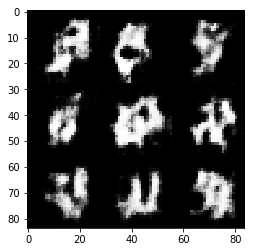

Epoch 1/2... Discriminator Loss: 1.7460... Generator Loss: 1.3522
Epoch 1/2... Discriminator Loss: 1.5854... Generator Loss: 1.1118
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 1.4910
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 1.9912


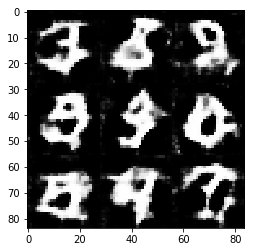

Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 1.6937... Generator Loss: 2.1644
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 1.9932
Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 1.1742


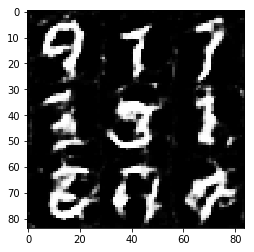

Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 1.2604
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 1.5274
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 2.6344
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 1.2445


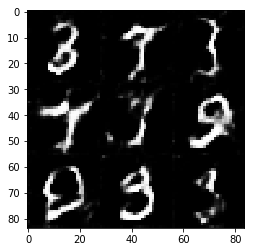

Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 1.3157
Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 1.4974
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 1.3175
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 1.5692


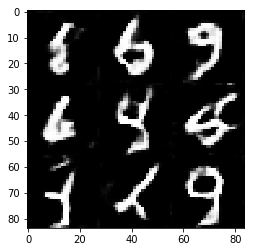

Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.9373
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 1.3758... Generator Loss: 0.7336
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 1.7300


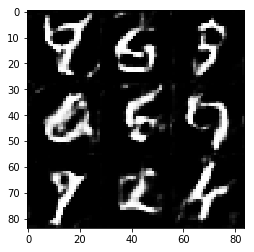

Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 1.1223
Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 1.5111... Generator Loss: 1.3553
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 1.2269


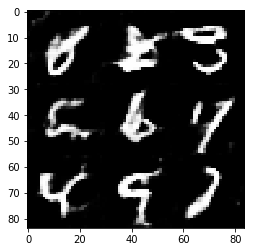

Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 1.6562
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 1.2429
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 2.1204
Epoch 1/2... Discriminator Loss: 1.6315... Generator Loss: 2.0307


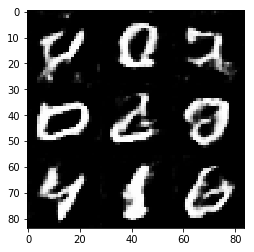

Epoch 1/2... Discriminator Loss: 1.1625... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 1.3111... Generator Loss: 1.0730
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 1.3972
Epoch 1/2... Discriminator Loss: 1.6510... Generator Loss: 1.0166


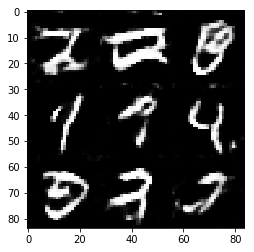

Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 1.1919
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 1.6406
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.9039


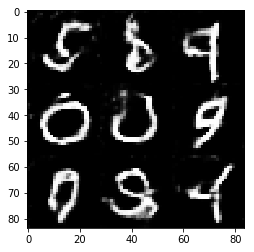

Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 1.1595
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 1.2750
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 1.1928
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 1.5779


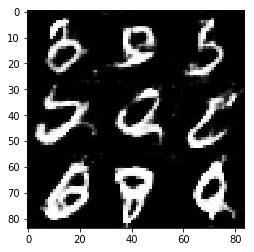

Epoch 1/2... Discriminator Loss: 1.4024... Generator Loss: 1.6405
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 1.0846
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 1.6821
Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 1.3566


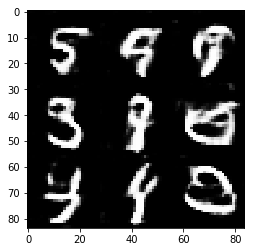

Epoch 1/2... Discriminator Loss: 1.6692... Generator Loss: 0.5870
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 1.2906
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 1.3077


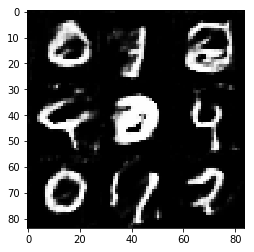

Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 1.7913
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.8602


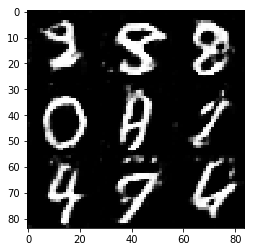

Epoch 1/2... Discriminator Loss: 1.4625... Generator Loss: 1.7387
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 1.3067
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 2.1054
Epoch 1/2... Discriminator Loss: 1.6939... Generator Loss: 1.4501


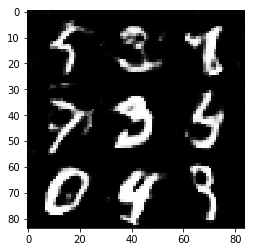

Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 2.5561
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 0.8174
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 1.6386
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 2.0378


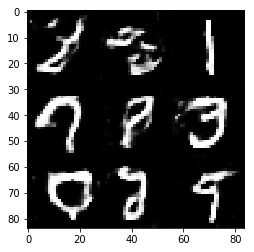

Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 1.5112
Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 1.8934
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.8084
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 1.2575


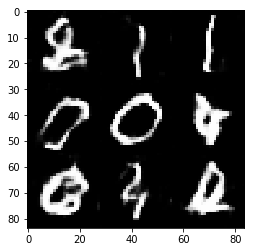

Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 1.6428
Epoch 1/2... Discriminator Loss: 1.6768... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 1.5336
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 1.1906


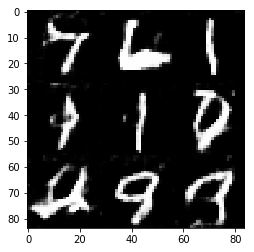

Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 1.0432
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 2.2833
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 1.7156


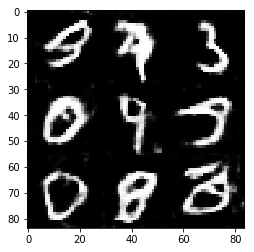

Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 1.2990
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 0.9539
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 1.5279


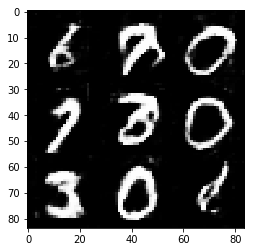

Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 1.7229
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 1.5662
Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 2.1387
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 1.3359


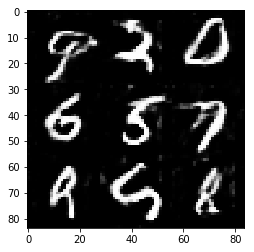

Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 1.3804
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 1.0439
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 1.3123
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 1.1983


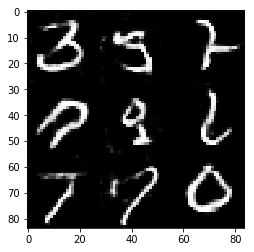

Epoch 2/2... Discriminator Loss: 1.1570... Generator Loss: 1.1703
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 1.3883
Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 1.6879
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 1.3917


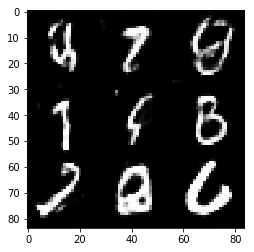

Epoch 2/2... Discriminator Loss: 1.0600... Generator Loss: 1.5674
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 1.5278
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 1.2839
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 2.0411


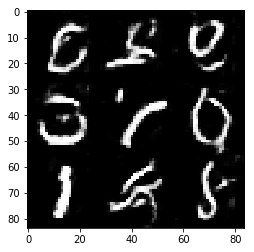

Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 1.3109
Epoch 2/2... Discriminator Loss: 1.2790... Generator Loss: 1.2665
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 1.1501
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 1.4583


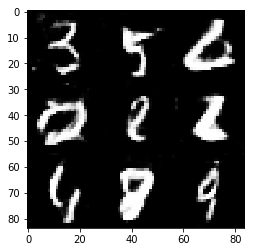

Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 1.9720
Epoch 2/2... Discriminator Loss: 1.2707... Generator Loss: 2.3552
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 2.7606
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 1.4663


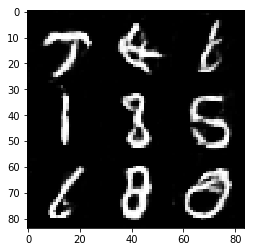

Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 1.1371
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 1.7411
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 1.6831
Epoch 2/2... Discriminator Loss: 1.0441... Generator Loss: 1.3903


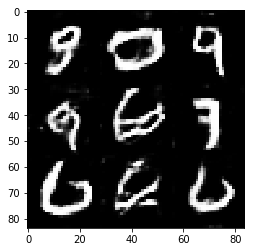

Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 1.6059
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 1.8469
Epoch 2/2... Discriminator Loss: 1.2252... Generator Loss: 1.3635
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 1.9013


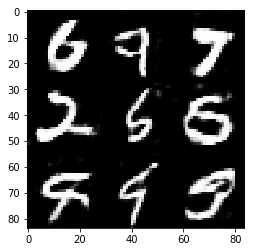

Epoch 2/2... Discriminator Loss: 1.1601... Generator Loss: 1.1065
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 1.1801
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 1.5536
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 1.1956


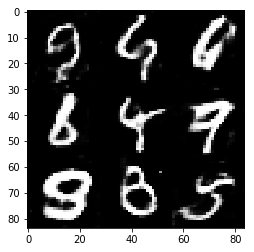

Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 2.0766
Epoch 2/2... Discriminator Loss: 1.1377... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 1.7167
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 1.6107


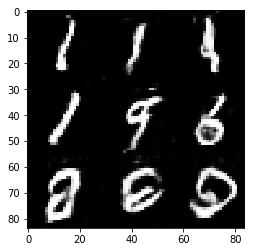

Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 1.3797
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 1.3255
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 2.2174
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.0688


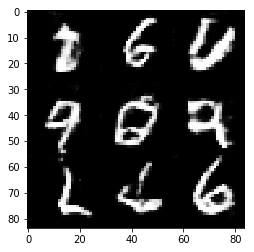

Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 1.2265
Epoch 2/2... Discriminator Loss: 1.1801... Generator Loss: 1.4995
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 1.4693
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 0.9078


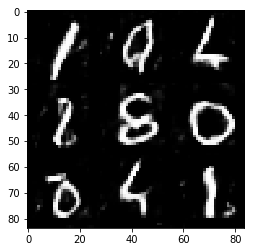

Epoch 2/2... Discriminator Loss: 1.2538... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 1.6123
Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 1.9887
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 1.3330


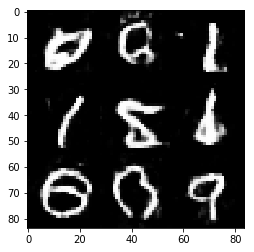

Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 1.2701
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 2.0430
Epoch 2/2... Discriminator Loss: 1.1201... Generator Loss: 1.2962
Epoch 2/2... Discriminator Loss: 1.1067... Generator Loss: 1.6423


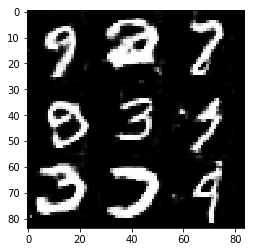

Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 1.3520
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 1.5313
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 1.2681


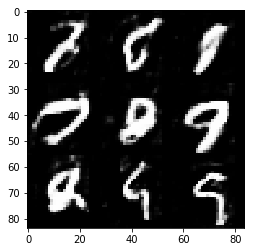

Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 1.4173
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 1.3278
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 1.9048
Epoch 2/2... Discriminator Loss: 1.1636... Generator Loss: 1.2332


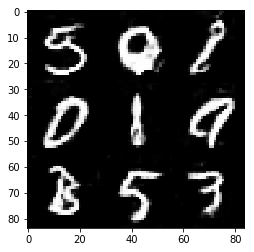

Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 2.0241
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 2.5179
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 1.2686
Epoch 2/2... Discriminator Loss: 1.4012... Generator Loss: 1.2313


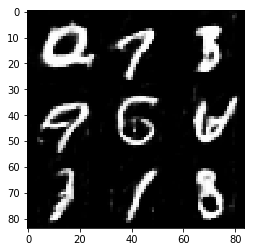

Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.8515
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 2.0546


In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 2.5940
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 2.2212
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 3.3215
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 2.3406


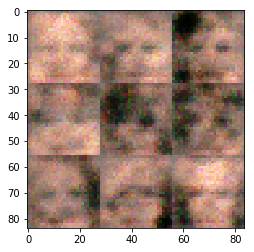

Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 1.9874
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.8042
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 2.2400
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 2.1354


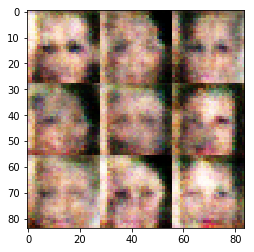

Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 2.0213
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 1.6561
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 1.7182
Epoch 1/2... Discriminator Loss: 1.0001... Generator Loss: 2.0392


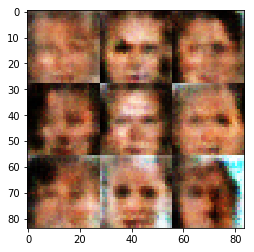

Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 2.3533
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 1.6306
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 1.7423
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 1.6280


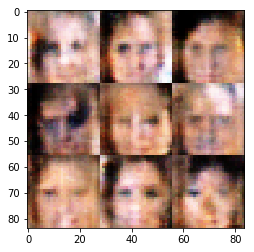

Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 1.7779
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 1.6437
Epoch 1/2... Discriminator Loss: 0.8848... Generator Loss: 1.9325
Epoch 1/2... Discriminator Loss: 1.0560... Generator Loss: 1.7077


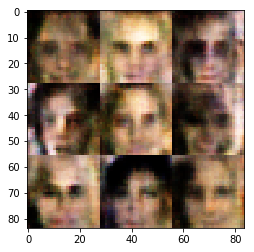

Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 1.8042
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 1.9725
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 1.4985
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 1.8667


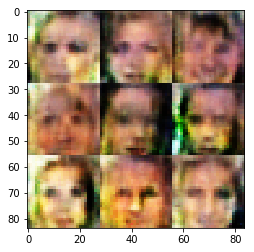

Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 1.7519
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 1.5164
Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 1.7586
Epoch 1/2... Discriminator Loss: 1.0990... Generator Loss: 1.5755


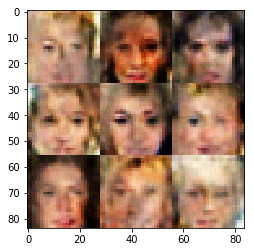

Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 1.2657
Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 1.1334
Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 1.2365... Generator Loss: 1.2491


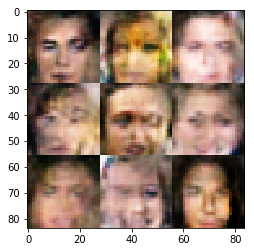

Epoch 1/2... Discriminator Loss: 1.2043... Generator Loss: 1.3710
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 1.2773
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 1.2610


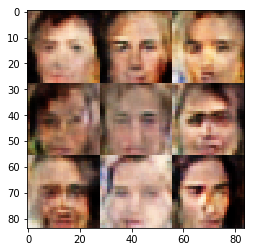

Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 1.0905
Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 1.1667
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 1.0897


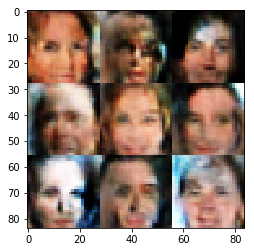

Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 1.3422
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 1.2801
Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 1.0860
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 1.2864


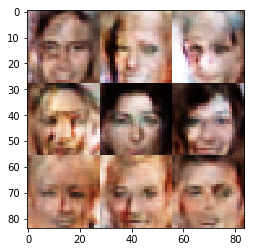

Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 1.1239
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 1.2122
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.9420
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.9539


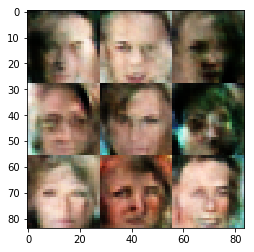

Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 1.4101
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 1.1398
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 1.1233
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 1.2027


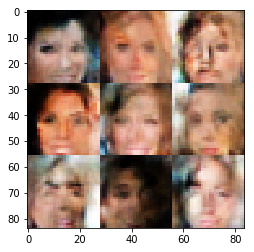

Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 1.2234
Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 1.1762
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 1.3045
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.9003


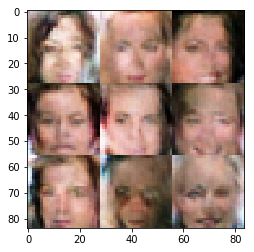

Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 1.2059
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 1.2903
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 1.2235


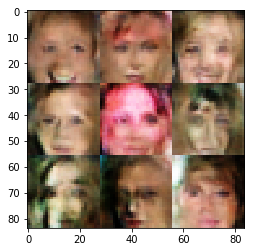

Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 1.3583... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 1.1481
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 1.2479


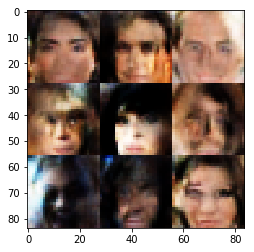

Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 1.2220
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 1.1680
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 1.0640
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 1.0834


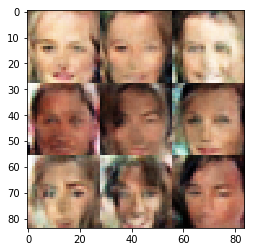

Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 1.1390
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 1.1520


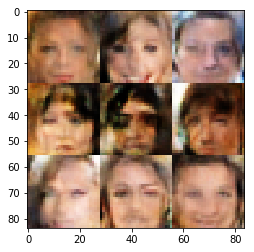

Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 1.0449
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 0.9858
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 1.1130
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 1.0240


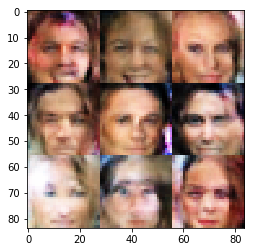

Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 1.1442


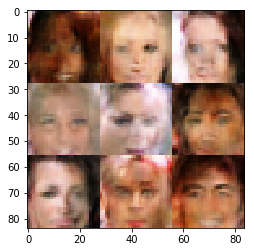

Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.9876
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 1.1176
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 1.1057
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 1.1081


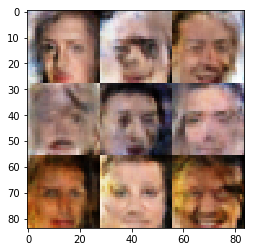

Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 1.0836
Epoch 1/2... Discriminator Loss: 1.2941... Generator Loss: 1.1205
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 1.2247


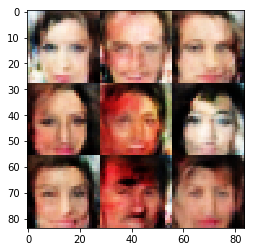

Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 1.1478
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 1.0238
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 1.0171
Epoch 1/2... Discriminator Loss: 1.2543... Generator Loss: 1.1143


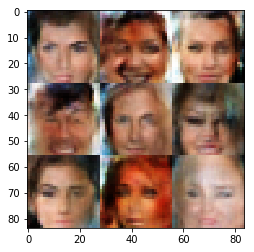

Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.9317
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 1.0158
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 1.0509
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 1.0631


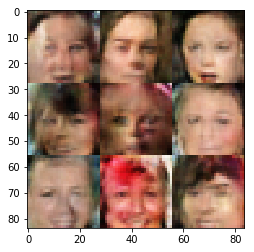

Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 1.0860
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 1.2138... Generator Loss: 0.9944
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 1.0558


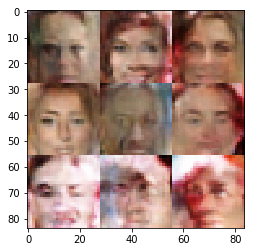

Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 1.0822
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 1.0195
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 1.0227


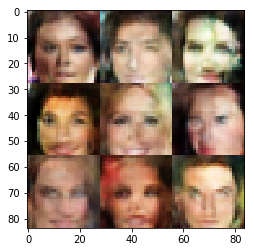

Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.9856
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 1.1714
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 1.0907


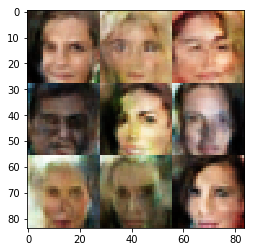

Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 1.2090... Generator Loss: 1.0437
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 1.0778
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 1.0159


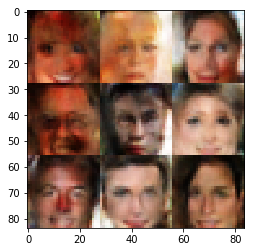

Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 1.1907
Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 1.0518
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 1.0650


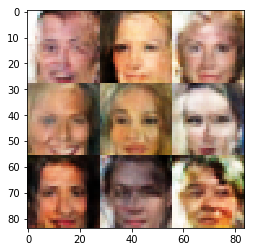

Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 1.0161


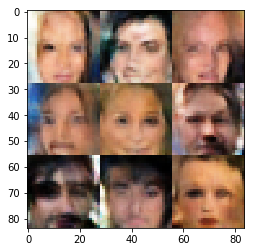

Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 1.0922
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.9855
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 1.0139


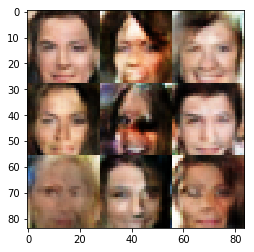

Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 1.0463
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.9899
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 1.1091
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 1.0280


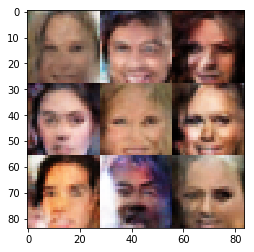

Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 1.0463
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 1.0720


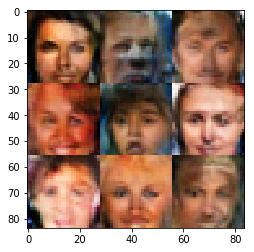

Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 1.0796
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 1.0754


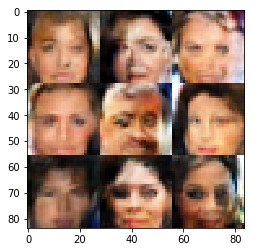

Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 1.0971
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 1.0266
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 1.0591


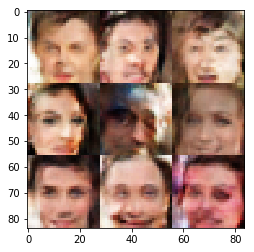

Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 1.0479
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 1.3208... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 1.0040


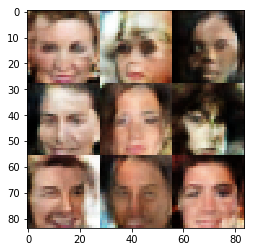

Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 1.0645
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 1.0068


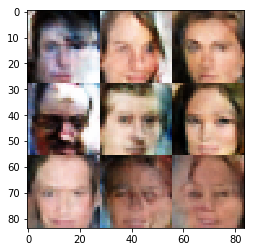

Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 1.0423
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.9126
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.9504


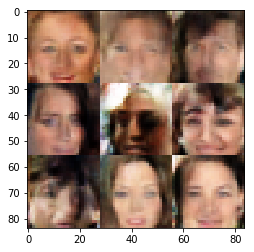

Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.9688
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.9890


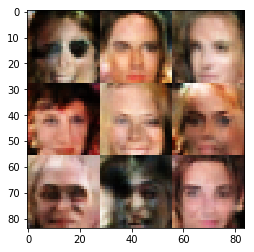

Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 0.9497
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 1.0951
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 1.0434


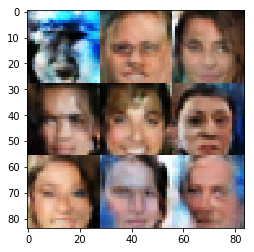

Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 1.3326... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 1.0012


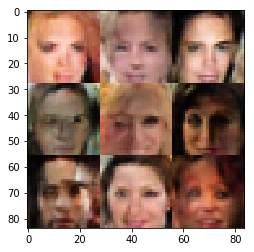

Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 1.0835
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 0.9492
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 1.0992


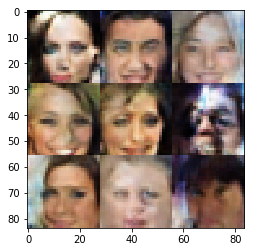

Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 1.0357
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 1.0860
Epoch 2/2... Discriminator Loss: 1.3084... Generator Loss: 1.0931
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.9678


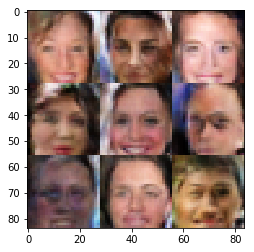

Epoch 2/2... Discriminator Loss: 1.4126... Generator Loss: 1.0394
Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 1.1372
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.9655


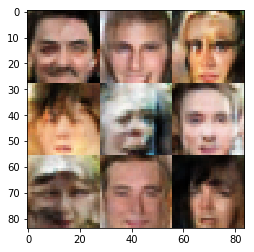

Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.9671
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.9865
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.9835


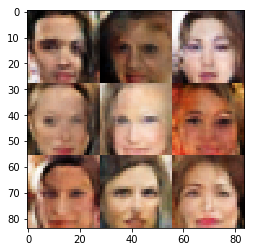

Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 1.2134... Generator Loss: 1.0212
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 1.1734


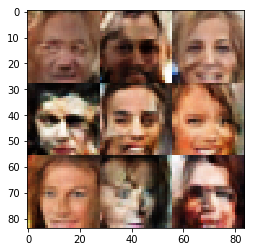

Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.9830
Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 1.1343
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.8900


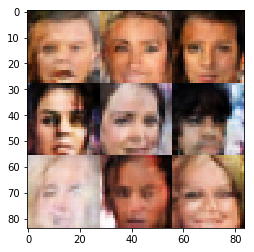

Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 1.3171... Generator Loss: 1.0258
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.9723


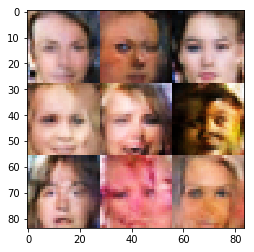

Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 1.0657
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 1.1223
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 1.1091


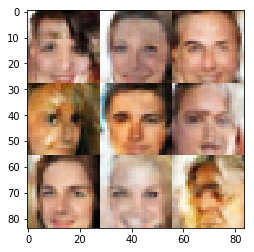

Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 1.0022
Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 1.1101
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.8913


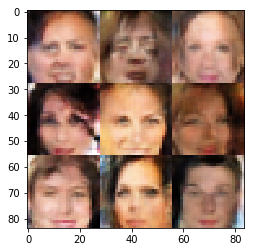

Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 1.1901
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 1.2062
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 1.2399


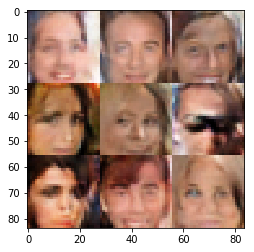

Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 1.0745
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.9591


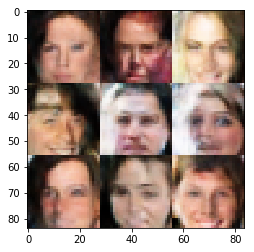

Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 1.0510
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.9170


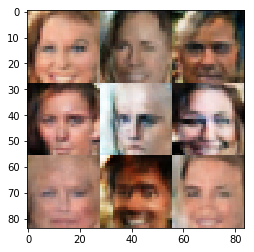

Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 1.0642
Epoch 2/2... Discriminator Loss: 1.2408... Generator Loss: 1.0723
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 1.0707


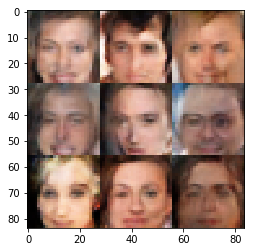

Epoch 2/2... Discriminator Loss: 1.2564... Generator Loss: 0.9826
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 1.0858
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 1.0514
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 1.0248


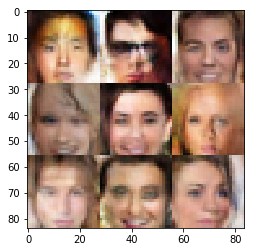

Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.9254
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 1.1692
Epoch 2/2... Discriminator Loss: 1.2279... Generator Loss: 1.0588
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 0.9762


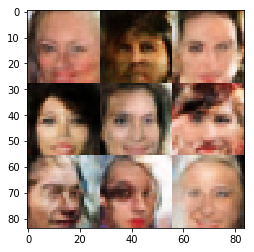

Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.9411
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 1.0059


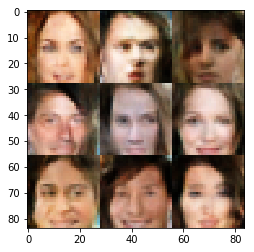

Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 1.0463
Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.9968
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 1.0318


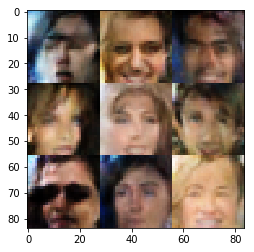

Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 1.1492
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 1.1295
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 1.1477


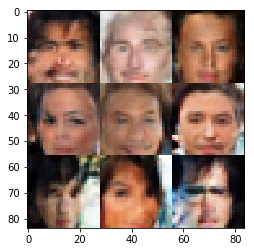

Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.9936
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 1.0973
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 0.9540


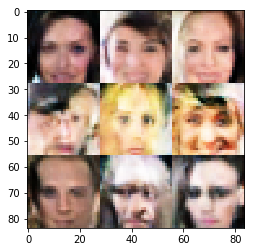

Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 1.0734
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 1.1063
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 1.2107
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 1.0630


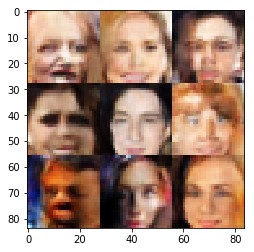

Epoch 2/2... Discriminator Loss: 1.2735... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 1.0715
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 1.0398


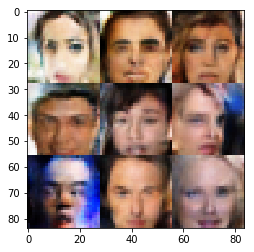

Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 1.0087
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 1.0143
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 1.0977


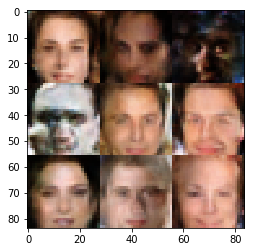

Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 1.2090
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.9701


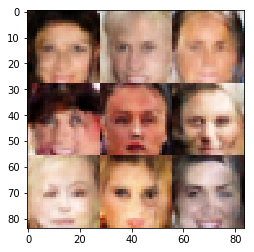

Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.9905
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 1.0612
Epoch 2/2... Discriminator Loss: 1.2230... Generator Loss: 1.0398
Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 1.0086


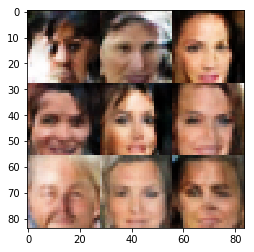

Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 1.2322
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 1.1700
Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 1.0592
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 1.0170


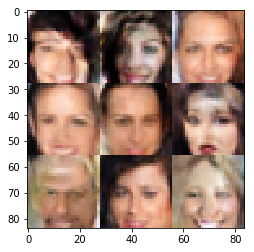

Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 1.0428
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.9649
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 1.0617
Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 1.0267


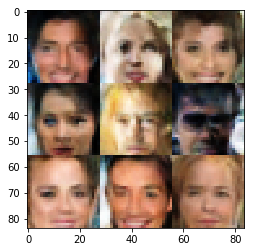

Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 1.0938
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 1.1094


In [13]:
batch_size = 60
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.